# **DQN-based Dynamic Job Shop Scheduling**

####**Description**:
-	**Jobs and Operations:** Each job consists of a sequence of operations that must be processed in a specific order. Each operation can be processed by one or multiple machines.

####**Optimization Objectives**:
-	**Minimizing Tardiness:** The agent aims to minimize the average tardiness of all jobs, which is the delay in completion beyond the due date.

**Reward Function:** The reward function is aligned with the problem objective, designed as the tardiness rate\\

####**Disruptions:**
We assume that $N_a$ new jobs arrive in the system according to a Poisson process, with interarrival times following an exponential distribution. This distribution is governed by the parameter 𝜆, which represents the expected time between the arrival of two consecutive jobs. \\
For a job $𝐽_𝑖$ consisting of $𝑛_𝑖$ operations arriving at time $𝐴_𝑖$, the due date $𝐷_𝑖$ is calculated using the formula:
$D_i=\ A_i+\left(\sum_{1\le j\le n_i}{\bar{p}}_{i,j}\right).DDT$ \\
Here, ${\bar{p}}_{i,j}={mean}_{M_k\in\mathcal{M}_{i,j}}p_{i,j,k}$ represents the average processing time of operation $O_{i,j}$ across all compatible machines, and DDT (Due Date Tightness) indicates the slack time tightness from a job’s arrival to its due date. \\

####**DQN Actions:**
The actions taken by the DQN are structured as follows:
-	**Heuristic Integration:** The environment supports the use of 10 heuristic policies, such as :
 - *Shortest Processing Time (SPT)*,
 - *Earliest Due Date (EDD)*,
 - *Minimal Critical Ratio (MCR)*,
 - *Most Remaining Time (MRT)*,
 - *Least Remaining Time (LRT)*.
 - *Smallest Slack Time (SLK)*.

A decision time $t$ is defined as every time a new job is inserted or cancelled or a machine completes an in-process operation.



**The state space of DQN includes the following features:**
- Actual tardiness rate of operations.
- Expected tardiness rate of operations.
- Actual tardiness rate of jobs.
- Expected tardiness rate of jobs.
- Completion rate of all the operations.
- Mean completion rate of jobs from the perspective of the number of completed operations.
- Standard deviation completion rate of jobs from the perspective of the number of completed operations.
- Difference between maximum and minimum completion rate of jobs from the perspective of the number of completed operations.
- Mean completion rate of jobs from the perspective of the completed processing time.
- Standard deviation completion rate of jobs from the perspective of the completed processing time.
- Due date of each candidate job.
- Remaining processing time of each candidate job.

In [ ]:
%%capture
!pip install -U kaleido
!pip install Optuna
!pip install gymnasium

In [ ]:
import gymnasium as gym
from gym import spaces, Env
import numpy as np
import math
from collections import deque
import pandas as pd
import random
import datetime
import plotly.figure_factory as ff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from torch.distributions import Categorical
import plotly.graph_objects as go
import copy
import optuna
from plotly.offline import iplot
import matplotlib.pyplot as plt

##**Actions (Operation Sequencing)**

In [ ]:
class OperationSelector:
    def __init__(self, world):
        self.world = world

    def select_operation(self, machine, heuristic):
        operation = heuristic(machine.legal_actions)
        return operation

    def MRT_DR_O(self, machine):
        """Select the operation with the most remaining processing time (MRT) for the current machine."""
        self.world.MRT_DR_O += 1  # Increment the counter for MRT
        return self.select_operation(machine, lambda operation: max(operation, key=lambda op: op[0].parent.remaining_processing_time)[0])

    def LRT_DR_O(self, machine):
        """Select the operation with the least remaining processing time (LRT) for the current machine."""
        self.world.LRT_DR_O += 1  # Increment the counter for LRT
        return self.select_operation(machine, lambda operation: min(operation, key=lambda op: op[0].parent.remaining_processing_time)[0])

    def SPT_DR_O(self, machine):
        """Select the operation with the shortest processing time (SPT) for the current machine."""
        self.world.SPT_DR_O += 1  # Increment the counter for SPT
        return self.select_operation(machine, lambda operation: min(operation, key=lambda op: op[1])[0])

    def EDD_DR_O(self, machine):
        """Select the operation with the earliest due date (EDD) for the current machine."""
        self.world.EDD_DR_O += 1  # Increment the counter for EDD
        return self.select_operation(machine, lambda operation: min(operation, key=lambda op: op[0].parent.due_date)[0])

    def MCR_DR_O(self, machine):
        """Select the operation with the minimal Critical Ratio (MCR) for the current machine (the whole job)."""
        self.world.MCR_DR_O += 1  # Increment the counter for MCR
        return self.select_operation(machine, lambda operation: min(operation, key=lambda op: (op[0].parent.due_date - self.world.total_timestamp) / op[0].parent.remaining_processing_time)[0])

    def SLK_DR_O(self, machine):
        """Select the operation with the smallest Slack Time (SLK) for the current machine."""
        self.world.SLK_DR_O += 1  # Increment the counter for SLK
        return self.select_operation(machine, lambda operation: min(operation, key=lambda op: (op[0].parent.due_date - self.world.total_timestamp - op[0].parent.remaining_processing_time))[0])

    def ATC_DR_O(self, machine):
        """Select the operation with the highest Apparent Tardiness Cost (ATC) for the current machine."""
        self.world.ATC_DR_O += 1  # Increment the counter for ATC
        k = 0.5  # Scaling parameter (can be tuned)
        return self.select_operation(machine, lambda operation: max(operation, key=lambda op: (np.exp(-(op[0].parent.due_date - self.world.total_timestamp - op[0].parent.remaining_processing_time) / (k * op[1]))) / op[1])[0])

## **Environement**

In [ ]:
class Job_Shop_Env(Env):
    def __init__(self, world, reset_callback=None, reward_callback=None, observation_callback=None, info_callback=None, done_callback=None):
        super(Job_Shop_Env, self).__init__()
        self.world = world
        self.operations_done = world.operations_done
        self.machines = world.machines
        self.jobs = world.jobs
        self.reward = 0
        # scenario callbacks
        self.reset_callback = reset_callback
        self.reward_callback = reward_callback
        self.observation_callback = observation_callback
        self.info_callback = info_callback
        self.done_callback = done_callback
        self.chosen_operation = OperationSelector(world)
        # used for plotting
        self.global_actions = []
        self.colors = [tuple([random.random() for _ in range(3)]) for _ in range(len(self.jobs) + 2)]
        self.action_mapping_operation_sequencing_list = [ # Action set for job sequencing
            lambda machine: self.chosen_operation.MRT_DR_O(machine),
            lambda machine: self.chosen_operation.LRT_DR_O(machine),
            lambda machine: self.chosen_operation.SPT_DR_O(machine),
            lambda machine: self.chosen_operation.EDD_DR_O(machine),
            lambda machine: self.chosen_operation.MCR_DR_O(machine),
            lambda machine: self.chosen_operation.ATC_DR_O(machine),
            lambda machine: self.chosen_operation.SLK_DR_O(machine)
        ]
        self.actions = len(self.action_mapping_operation_sequencing_list)
        # configure spaces
        self.configure_spaces()

    def configure_spaces(self):
      # state space
      state = self.observation_callback(self.world)
      self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state.shape, dtype=np.float32)
      # action space
      self.action_space = spaces.Discrete(self.actions)

    def get_legal_actions(self, machine): # Return the candidate operations of a specific machine
      operations_done_set_info = {(op.parent, op.order) for op in self.world.operations_done}
      machine.legal_actions = [operation for operation in machine.operations_to_process if operation[0].parent.legal and operation[0] not in self.world.operations_done and ((operation[0].parent, operation[0].order - 1) in operations_done_set_info or operation[0].order==0)]

    # A function to process operation selection for processing
    def execute_operation(self, machine, operation):
      machine.assigned_op += 1
      operation_parent = operation.parent
      operation_parent.legal = False
      machine.action = [operation, operation.available_machines[machine], self.world.total_timestamp * 60]
      machine.workload += operation.available_machines[machine]
      # Track tardy operations of the current job
      if operation_parent.tardy_operations == 0 and self.world.total_timestamp >= operation_parent.due_date and operation_parent.remaining_processing_time > 0: # Track the actual tardiness of the job that includes the current operation
        operation_parent.tardy_operations = len(operation_parent.operations) - operation_parent.op_processed
      operation_parent.remaining_processing_time -= int(operation.average_processing_time) # Update the remaining processing time of the job
      operation_parent.op_processed += 1
      operation_parent.CRJ = operation_parent.op_processed / len(operation_parent.operations) # Update the completion rate of the job
      self.global_actions.extend([[machine.name] + machine.action]) # Update the list containing all the actions
      machine.request = False

    def update_state(self):  # Advance the shop floor to the next closest event
      # Find the closest job arrival, the minimum processing time among machines, and the closest failure
      closest_arrival_time = min((job.arrival_time - self.world.total_timestamp for job in self.jobs if job.arrival_time > self.world.total_timestamp), default=500000)
      min_PT = min((machine.action[1] for machine in self.machines if machine.action[1] > 0), default=500000)

      # Compute the minimum of the key events: operation completion, job insertion, and machine failure
      min_event = min(closest_arrival_time, min_PT)

      #The following code does consider 3 scenarios : a combination of the two events (operation completion and new job insertion)
      if closest_arrival_time == min_PT and min_PT != 500000: # All the events happen simultanously
        self.handle_case1(min_PT)
      elif closest_arrival_time < min_PT: # Job insertion
        self.handle_case2(closest_arrival_time)
      elif closest_arrival_time > min_PT:
        self.handle_case3(min_PT)  # Operation completion

    def step(self, action, **kwargs):
      machine = self.world.ready_machine # The idle machine that requests processing at the current decision time

      # Handle operation sequencing
      operation_to_process = self.action_mapping_operation_sequencing_list[action](machine)
      self.execute_operation(machine, operation_to_process)

      self.reward = self._get_reward
      obs_n = self._get_obs

      #If there are no other processing requests, move the shop floor forward min_PT steps
      while True:
        # Check if there is request from any machine and legal jobs or all jobs are completes
        if all(job.CRJ==1 for job in self.jobs) or (any(machine.request for machine in self.machines) and any(job.legal for job in self.jobs)):
          break
        self.update_state()

      done = all(job.CRJ==1 for job in self.jobs)

      return obs_n, self.reward, done, {}

    # A function to handle job arrivals
    def handle_job_arrivals(self): #The new job arrival process is considered by adding the newly arrived job to the waiting buffer.
      new_jobs = [job for job in self.jobs if job.arrival_time == self.world.total_timestamp]
      self.world.new_job.extend(new_jobs)
      for job in new_jobs:
        job.legal = job.inserted = True
      for machine in self.machines:
        machine.actions += sum(1 for job in new_jobs for op in job.operations if machine in op.available_machines)

    def handle_case1(self, min_PT): #Case of job insertion and a machine completes the in-process operation
      self.world.total_timestamp += min_PT
      self.handle_job_arrivals()
      machines_min_PT = [machine for machine in self.machines if machine.action[1] == min_PT]
      self.process_ready_machines(machines_min_PT, min_PT)
      other_machines = [machine for machine in self.machines if machine not in machines_min_PT]
      self.process_other_machines(other_machines, min_PT)

    def handle_case2(self, closest_arrival_time): #Case of a new job insertion only
      self.world.total_timestamp += closest_arrival_time
      self.handle_job_arrivals()
      self.process_other_machines(self.machines, closest_arrival_time)

    def handle_case3(self, min_PT): #Case when only a machine completes processing
      self.world.total_timestamp += min_PT
      machines_min_PT = [machine for machine in self.machines if machine.action[1] == min_PT]
      self.process_ready_machines(machines_min_PT, min_PT)
      other_machines = [machine for machine in self.machines if machine not in machines_min_PT]
      self.process_other_machines(other_machines, min_PT)

    # A function to update machines that finish the in-process operation
    def process_ready_machines(self, machines_min_PT, min_PT):
      for machine in machines_min_PT :
        action = machine.action[0]
        self.world.operations_done.append(action)  # Add the completed operation to the list of processed operations
        machine.utilization = machine.workload / self.world.total_timestamp
        parent = action.parent
        if action.order == len(parent.operations) - 1:
          parent.finish_processing = self.world.total_timestamp
        parent.legal = parent.op_assigned != len(parent.operations)
        self.get_legal_actions(machine) #Get legal actions/operations
        machine.action = [0, 0, 0] #Considering both machines that finished processing and those where the CM/PdM is completed
        machine.request = any(machine.legal_actions) #Turn on the machine´s request if it has any candidate operation

    # A function to update the other machines
    def process_other_machines(self, other_machines, x):
      for machine in other_machines:
        machine.action[1] = max(machine.action[1] - x, 0) #All busy machines move x steps
        if all(y==0 for y in machine.action): # Machines that were already waiting because they had no candidate operations in the previous decision time
          self.get_legal_actions(machine) #Get legal actions/operations
          machine.request = any(machine.legal_actions) #Turn on the machine´s request if it has any candidate operation
        machine.utilization = machine.workload / self.world.total_timestamp

    @property
    def _get_makespan(self): # Get the maximal completion time of the last operation
      return self.world.total_timestamp

    def reset(self):
      self.global_actions = []
      # reset world
      return self.reset_callback(self.world)

    @property
    def _get_obs(self):
      return self.observation_callback(self.world) if self.observation_callback is not None else np.zeros(0)

    @property
    def _get_reward(self):
      return self.reward_callback(self.world) if self.reward_callback else 0.0

    #render with machines in the y-axis (GANTT DIAGRAM)
    def render(self, mode='human'):
      df = [{
        "Task": str(action[0]),
        "Start": datetime.datetime.fromtimestamp(action[3]).strftime('%Y-%m-%d %H:%M:%S'),  # Format the timestamp as needed
        "Finish": datetime.datetime.fromtimestamp(action[3] + action[2] * 60).strftime('%Y-%m-%d %H:%M:%S'),
        "Resource": str(action[1].parent.name)
      } for action in self.global_actions]

      fig = ff.create_gantt(df, index_col='Resource', colors=self.colors, show_colorbar=True, group_tasks=True, bar_width=0.25)

      fig.update_yaxes(autorange="reversed", tickfont=dict(size=20, family='Arial', color='black'))
      fig.update_xaxes(tickfont=dict(size=20, family='Arial', color='black'))
      fig.update_layout(legend=dict(title_font_family="Times New Roman", font=dict(size=20), traceorder='normal', bordercolor='black', borderwidth=2, orientation="v"),
                        autosize=False, width=1500, height=600)
      return fig

# **Environment Construction**

In [ ]:
def make_env():
    # create world
    world = Scenario().make_world()
    env = Job_Shop_Env(world, reset_callback=Scenario().reset_world, reward_callback=Scenario().reward, observation_callback=Scenario().observation)
    return env

## **World**

In [ ]:
class Operation(object):
    __slots__ = ['name', 'id', 'parent', 'order', 'available_machines', 'average_processing_time']

    def __init__(self):
      self.name = ''
      self.parent = None
      self.order = None
      self.available_machines = []
      self.average_processing_time = 0

class Job(object):
    __slots__ = ['name', 'id', 'operations', 'arrival_time', 'due_date', 'op_assigned', 'op_processed', 'processing_time', 'remaining_processing_time', 'tardy_operations',
                 'CRJ', 'finish_processing', 'tardiness_cost', 'legal', 'inserted', 'cancelled']

    def __init__(self):
      self.name = ''
      self.operations = []
      self.arrival_time = self.due_date = self.op_assigned = self.processing_time = 0
      self.remaining_processing_time = self.tardy_operations = self.CRJ = self.finish_processing = 0
      self.tardiness_cost = 0
      self.legal = True
      self.inserted = self.cancelled = False

class Machine(object):
  __slots__ = ['name', 'id', 'operations_to_process', 'legal_actions', 'request', 'action', 'actions', 'availability', 'assigned_op',
                'utilization', 'workload', 'assigned_op']

  def __init__(self):
    self.name = ''
    self.operations_to_process = self.legal_actions = []
    self.action = [0, 0, 0]
    self.request = True
    self.utilization = self.workload = self.assigned_op = 0

class World(object):
  __slots__ = ['DDT', '_lambda', 'machines', 'operations', 'jobs', 'operations_done', 'total_operations', 'ready_machine', 'new_job',
               'total_timestamp', 'tardiness_rate', 'start', 'MRT_DR_O', 'LRT_DR_O', 'SPT_DR_O', 'EDD_DR_O', 'MCR_DR_O',
               'SLK_DR_O', 'CR_DR_O', 'ATC_DR_O', 'LSPO_DR_O', '_lambda']
  def __init__(self):
    self.new_job = None
    self.machines = []
    self.operations = []
    self.jobs = []
    self.operations_done = []
    self.ready_machine = None

In [ ]:
# defines scenario upon which the world is built
class BaseScenario(object):
    # create elements of the world
    def make_world(self):
        raise NotImplementedError()
    # create initial conditions of the world
    def reset_world(self, world):
        raise NotImplementedError()

#**Scenario**

In [ ]:
#This scenario will create many data sets with one disturbance : job insertion
class Scenario(BaseScenario):
  def make_world(self):
      world = World()
      world.DDT = 0.5 # Due date tightness
      # add machines
      world.machines = [Machine() for _ in range(10)]
      p = 0 # To increment machines' IDs
      for i, machine in enumerate(world.machines, 1):
        machine.id = p
        machine.name = 'Machine %d' % i
        p += 1

      # add jobs and operations
      available_machines_per_operation=[]
      n = 50
      world.jobs = [Job() for _ in range(n)]
      p = 0
      for i, job in enumerate(world.jobs,1):
          job.name = 'Job %d' % i
          job.id = i - 1
          op = random.randint(6,10) # Tasks
          job.operations = [Operation() for _ in range(op)]
          for k, operation in enumerate(job.operations,1):
            operation.id = p
            p += 1
            operation.name = 'Operation %d,%d' % (i,k)
            operation.parent = job
            operation.order = k - 1
            available_machines = random.sample(world.machines, random.randint(1, 10)) # An operation could be processed by one or multiple machines
            operation.available_machines = {machine: random.randint(60, 120) for machine in available_machines} # procesing time on each machine
            operation.average_processing_time = np.mean(list(operation.available_machines.values()))
            for agent, time in operation.available_machines.items():
              agent.operations_to_process.extend([(operation, time)])

          job.processing_time = sum([int(operation.average_processing_time) for operation in job.operations])
          job.remaining_processing_time = job.processing_time
          job.tardiness_cost = round(random.uniform(0.3,1.3), 1)  #tardiness cost per minute

      world.operations = sum([len(job.operations) for job in world.jobs])
      #arrival time of jobs
      random_initial_jobs = [job.name for job in random.sample(world.jobs, 25)]
      job_dict = {job.name: job for job in world.jobs}
      random_initial_jobs = [job_dict[x] for x in random_initial_jobs]
      print("{} jobs are available at time t = 0".format(len(random_initial_jobs)))

      for job in random_initial_jobs:
        job.arrival_time = 0
        #Due data = arrival_time + sum(processing time) * DDT
        job.due_date = int(job.arrival_time + job.processing_time * world.DDT) #min

      world._lambda = random.choice([50, 100, 150])
      x= 1 / world._lambda    # A new job (on average) is inseterd each 50,100, or 200 minutes
      _arrival_time = 0

      for job in list(set(world.jobs) - set(random_initial_jobs)):
          #Get the next probability value from Uniform(0,1)
          p = random.random()
          #Plug it into the inverse of the CDF of Exponential(_lambda)
          _inter_arrival_time = -math.log(1.0 - p)/x
          #Add the inter-arrival time to the running sum
          _arrival_time += _inter_arrival_time
          job.arrival_time = int(_arrival_time)
          #Due data = arrival_time + sum(processing time) * DDT
          job.due_date = int(job.arrival_time + job.processing_time * world.DDT) #min

      # make initial conditions
      self.reset_world(world)
      print("DDT :",world.DDT, "lambda :", world._lambda, "there are {} jobs".format(len(world.jobs)),"and {} machines".format(len(world.machines)), "and {} operations".format(sum([len(job.operations) for job in world.jobs])), "and {} minutes".format(sum([int(operation.average_processing_time) for job in world.jobs for operation in job.operations])))
      return world

  def reset_world(self, world):
      # set initial states
      self.n_actions_agents = [len(agent.operations_to_process) for agent in world.machines]
      world.total_operations = sum([len(job.operations) for job in world.jobs])
      world.operations_done = []
      world.new_job = []
      world.ready_machine = world.machines[0]
      # List of attributes to set to 0
      attributes_to_reset = ['total_timestamp', 'tardiness_rate', 'MRT_DR_O', 'LRT_DR_O', 'SPT_DR_O', 'EDD_DR_O', 'MCR_DR_O', 'SLK_DR_O', 'CR_DR_O', 'ATC_DR_O', 'LSPO_DR_O']
      # Loop through the list and set each attribute to 0
      for attr in attributes_to_reset:
        setattr(world, attr, 0)

      for job in world.jobs:
        job.CRJ = job.op_assigned = job.op_processed = 0
        job.cancelled= False
        job.remaining_processing_time = job.processing_time
        job.tardy_operations = job.finish_processing = 0
        job.inserted = job.legal = job.arrival_time == 0

      # List of attributes to set to 0
      attributes_to_reset = ['workload', 'assigned_op', 'utilization', 'assigned_op']

      for machine_id, machine in enumerate(world.machines):
        machine.actions =  sum(1 for op in machine.operations_to_process if op[0].parent.arrival_time <= world.total_timestamp)
        machine.legal_actions = [operation for operation in machine.operations_to_process if operation[0].order == 0 and operation[0].parent.legal]
        machine.request = any(machine.legal_actions)
        machine.availability = 1
        machine.action = [0, 0, 0]

        # Reset machine-level attributes
        for attr in attributes_to_reset:
          setattr(machine, attr, 0)

  def expected_tardiness_rate(self, world, filtered_jobs):
    expected_tardy_operations = 0
    Total = sum([len(job.operations) for job in filtered_jobs])
    average_CT = int(np.mean([machine.action[1] for machine in world.machines]))
    for job in filtered_jobs:
      if world.total_timestamp < job.due_date <= world.total_timestamp + average_CT + job.remaining_processing_time:
        total_time = 0
        expected_tardiness_time = world.total_timestamp + average_CT + job.remaining_processing_time - job.due_date
        operation_times = [op.average_processing_time for op in reversed(job.operations)]
        cumulative_time = np.cumsum(operation_times)
        expected_tardy_operations += np.sum(cumulative_time <= expected_tardiness_time)
    return expected_tardy_operations/Total

  def actual_tardiness_rate(self, world, jobs):
    Ntard = 0
    Total = sum([len(job.operations) for job in jobs])
    Ntard = sum([job.tardy_operations for job in jobs])
    Ntard += sum([len(job.operations) for job in jobs if job.remaining_processing_time == job.processing_time and world.total_timestamp >= job.due_date])
    return Ntard/Total

  def reward(self, world):
    #Total tardiness rates at the current decision time
    #jobs_in_the_buffer = [job for job in world.jobs if job.arrival_time <= world.total_timestamp]
    #else:
    jobs_in_the_buffer = [op[0].parent for op in world.ready_machine.legal_actions if op[0].parent.arrival_time <= world.total_timestamp]

    actual_tardiness_rate = self.actual_tardiness_rate(world, jobs_in_the_buffer)
    expected_tardiness_rate = self.expected_tardiness_rate(world, jobs_in_the_buffer)
    world.tardiness_rate = self.actual_tardiness_rate(world, [job for job in world.jobs if job.arrival_time <= world.total_timestamp])

    return - (actual_tardiness_rate + expected_tardiness_rate)

  def observation(self, world):
      #Info related to jobs
      jobs_in_the_buffer = [op[0].parent for op in world.ready_machine.legal_actions if op[0].parent.arrival_time <= world.total_timestamp]
      #Completion rate of all the operations
      total_operations = sum(len(job.operations) for job in jobs_in_the_buffer)
      completion_rate = sum([job.op_processed for job in jobs_in_the_buffer]) / total_operations
      CRJ_op = [job.CRJ for job in jobs_in_the_buffer]
      #Average completion rate from the perspective of the number of completed operations
      average_CRJ_op = np.mean(CRJ_op)
      #Std completion rate from the perspective of the number of completed operations
      std_CRJ_op = np.std(CRJ_op)
      #Average completion rate from the perspective of the completed processed time
      CRJ_time = [(job.processing_time - job.remaining_processing_time) / (job.processing_time) for job in jobs_in_the_buffer]
      average_CRJ_time = np.mean(CRJ_time)
      #Std completion rate from the perspective of the completed processed time
      std_CRJ_time = np.std(CRJ_time)
      #Total operations tardiness rate at the current decision time
      actual_tardiness_rate = self.actual_tardiness_rate(world, jobs_in_the_buffer)
      expected_tardiness_rate = self.expected_tardiness_rate(world, jobs_in_the_buffer)
      #Actual Job tardiness rate
      actual_tardiness_rate_job = sum([1 for job in jobs_in_the_buffer if job.tardy_operations > 0]) / len(jobs_in_the_buffer)
      #Expected Job tardiness rate
      average_CT = int(np.mean([machine.action[1] for machine in world.machines]))
      expected_tardiness_rate_job = sum([1 for job in jobs_in_the_buffer if world.total_timestamp < job.due_date <= world.total_timestamp + average_CT + job.remaining_processing_time]) / len(jobs_in_the_buffer)
      # Maximal/Minimal remaining time of the candidate jobs
      remaining_time = [job.remaining_processing_time/job.processing_time for job in jobs_in_the_buffer]
      # Minimal critial ratio
      min_critical_ratio = min([(job.due_date - world.total_timestamp) / job.remaining_processing_time if job.remaining_processing_time != 0 else 0 for job in jobs_in_the_buffer])
      spt_feature = min([job.remaining_processing_time for job in jobs_in_the_buffer])
      edd_feature = min([job.due_date for job in jobs_in_the_buffer])
      return np.array([completion_rate, actual_tardiness_rate_job, expected_tardiness_rate_job, actual_tardiness_rate, expected_tardiness_rate, average_CRJ_op, std_CRJ_op, average_CRJ_time, std_CRJ_time, min_critical_ratio, spt_feature, edd_feature], dtype=np.float32)

# **Standard Replay Buffer**

In [ ]:
class Memory(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
        self.n_entries = 0
    def add(self,transitions):
        self.buffer.append(transitions)
        if self.n_entries < self.capacity:
          self.n_entries += 1
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return zip(*batch)
    def __len__(self):
        return len(self.buffer)

# **Scheduling Network**

In [ ]:
class Policy(nn.Module):
  def __init__(self, state_size, action_size, hidden_layers, neurons_per_layer):
    super(Policy, self).__init__()
    # Initialize your model and move it to the GPU
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the input layer
    self.input_layer = nn.Linear(state_size, neurons_per_layer[0]).to(self.device)

    # Create hidden layers
    self.hidden_layers = nn.ModuleList()
    for i in range(1, hidden_layers):
      self.hidden_layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]).to(self.device))

    self.output = nn.Linear(neurons_per_layer[hidden_layers - 1], action_size).to(self.device)

  def forward(self, x):
    x = torch.as_tensor(x, dtype=torch.float32).to(self.device)
    x = F.relu(self.input_layer(x))

    # Pass through hidden layers
    for hidden_layer in self.hidden_layers:
      x = F.relu(hidden_layer(x))

    output = self.output(x)
    return output

## **DQN AGENT**

In [ ]:
class DQNAgent:
    def __init__(self, input_dim, action_size, hidden_layers, neurons_per_layer, batch_size):
      self.state_size = input_dim
      self.action_size = action_size
      self.batch_size = batch_size
      super(DQNAgent,self).__init__()
      self.train_start = 1000 # The agent starts learning after 1000 steps (collected experiences)
      self.memory_size = 100000
      # Initialize your model and move it to the GPU
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.memory = Memory(self.memory_size)
      self.gamma = 0.99    # discount rate
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.loss_fn = nn.MSELoss()
      self.model = Policy(input_dim, action_size, hidden_layers, neurons_per_layer).to(self.device)
      #self.model.apply(self.weights_init)
      self.target_model = deepcopy(self.model).to(self.device)
      # Copy all parameters from model to target_model
      self.target_model.load_state_dict(self.model.state_dict())
      self.explore_step = 10000
      self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
      self.tau = 0.01
      self.update_rate = 10000     # Number of steps until updating the target network
      self.learn_step_counter = 0
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    # weight xavier initialize
    def weights_init(self, m):
      classname = m.__class__.__name__
      if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)

    def soft_update(self):
      """Soft update model parameters.
      θ_target_new = τ*θ_local + (1 - τ)*θ_target_old
      """
      for target_param, local_param in zip(self.target_model.parameters(), self.model.parameters()):
        target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def update(self):
      if self.memory.n_entries < self.train_start:
        return

      # Sample from replay memory
      states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

      # Convert to PyTorch tensors and ensure proper tensor construction
      states = torch.tensor(np.array(states, dtype=np.float32), dtype=torch.float32).to(self.device)
      actions = torch.tensor(np.array(actions, dtype=np.int64), dtype=torch.long).to(self.device)
      rewards = torch.tensor(np.array(rewards, dtype=np.float32), dtype=torch.float32).to(self.device)
      next_states = torch.tensor(np.array(next_states, dtype=np.float32), dtype=torch.float32).to(self.device)
      dones = torch.tensor(np.array(dones, dtype=np.float32), dtype=torch.float32).to(self.device)

      # Forward pass for Q-values of current states
      q_values = self.model(states)
      # Forward pass for target Q-values of next states
      next_q_values = self.target_model(next_states)
      # Gather the Q-values corresponding to the actions taken
      q_values = q_values.gather(1, actions.unsqueeze(1)) # unsqueeze: adds an additional dimension to match the dimensions of the actions tensor with the q_values tenso
      # Calculate expected Q-values using the Bellman equation
      expected_q_values = rewards + self.gamma * (1 - dones) * next_q_values.max(1)[0].detach()
      expected_q_values = expected_q_values.unsqueeze(1)
      # Calculate loss between current Q-values and expected Q-values
      loss = self.loss_fn(q_values, expected_q_values)

      # Backpropagation and optimization step
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Update the target network
      if self.learn_step_counter % self.update_rate == 0:
        self.soft_update()
      self.learn_step_counter += 1

      # Update epsilon for epsilon-greedy exploration
      if self.epsilon > self.epsilon_min:
        self.epsilon -= self.epsilon_decay

    def remember(self, state, action, reward, next_state, done): # Add the sample to the memory
      self.memory.add((state, action, reward, next_state, done))

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
      if np.random.rand() <= self.epsilon:
        return random.randrange(self.action_size)
      state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
      with torch.no_grad():
        action_values = self.model(state)
      return np.argmax(action_values.cpu().data.numpy())

#**Training Framework**

In [ ]:
def train_agents(hidden_layers, neurons_per_layer, batch_size):

  scores = []
  best_score = np.inf
  EPISODES = 100

  agent = DQNAgent(input_dim=state_dim, action_size=output_dim, hidden_layers=hidden_layers, neurons_per_layer=neurons_per_layer, batch_size=batch_size)
  print("........................................Collecting Experience........................................")

  # Create Environment
  env = make_env()
  world = env.world
  for e in range(EPISODES):
    env.reset()
    done = False

    while not done:
      # Check for available jobs and idle machines
      if not (any(job.legal for job in world.jobs) and any(machine.request for machine in world.machines)):
        env.update_state()  # Move the shop floor forward if no machines are ready or no legal jobs
        continue

      world.ready_machine = next((machine for machine in random.sample(world.machines, len(world.machines)) if machine.request), None)
      env.get_legal_actions(world.ready_machine) # Update the legal operations for the machine that requests processing

      if world.ready_machine.legal_actions:
        state = env._get_obs
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.update() # Update the agent if enough experiences have been collected
      else:
        world.ready_machine.request = False  # No candidate operation, wait for the next decision time

    scores.append(world.tardiness_rate)

    if world.tardiness_rate < best_score:
      best_score = world.tardiness_rate

    print("episode: {}/{}, tardiness rate: {:.2f}".format(e, EPISODES, world.tardiness_rate))

    env.close()

  # Plot the reward curve during training
  plt.plot(scores)

  plt.title("Tardiness rate")
  plt.xlabel("Episode")
  plt.ylabel("Value")

  # Show the plot
  plt.show()
  return best_score

# **Hyperparameters Optimization**

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    hidden_layers = trial.suggest_int("hidden_layers", 5, 9)
    neurons_per_layer = [trial.suggest_int(f"neurons_per_layer_{i}", 64, 256) for i in range(hidden_layers)]

    mean_reward = train_agents(hidden_layers, neurons_per_layer, batch_size)

    return -mean_reward  # We want to maximize the mean reward

# **Main Training Loop**

[I 2024-09-28 18:27:42,209] A new study created in memory with name: no-name-25a6d511-af16-4ffe-a40e-62b2150a45f8


25 jobs are available at time t = 0
DDT : 0.5 lambda : 50 there are 50 jobs and 10 machines and 417 operations and 37365 minutes


  0%|          | 0/1 [00:00<?, ?it/s]

........................................Collecting Experience........................................
25 jobs are available at time t = 0
DDT : 0.5 lambda : 50 there are 50 jobs and 10 machines and 402 operations and 36085 minutes
episode: 0/100, tardiness rate: 0.84
episode: 1/100, tardiness rate: 0.84
episode: 2/100, tardiness rate: 0.84
episode: 3/100, tardiness rate: 0.83
episode: 4/100, tardiness rate: 0.84
episode: 5/100, tardiness rate: 0.82
episode: 6/100, tardiness rate: 0.83
episode: 7/100, tardiness rate: 0.84
episode: 8/100, tardiness rate: 0.84
episode: 9/100, tardiness rate: 0.81
episode: 10/100, tardiness rate: 0.82
episode: 11/100, tardiness rate: 0.79
episode: 12/100, tardiness rate: 0.80
episode: 13/100, tardiness rate: 0.81
episode: 14/100, tardiness rate: 0.80
episode: 15/100, tardiness rate: 0.80
episode: 16/100, tardiness rate: 0.76
episode: 17/100, tardiness rate: 0.79
episode: 18/100, tardiness rate: 0.80
episode: 19/100, tardiness rate: 0.77
episode: 20/100, ta

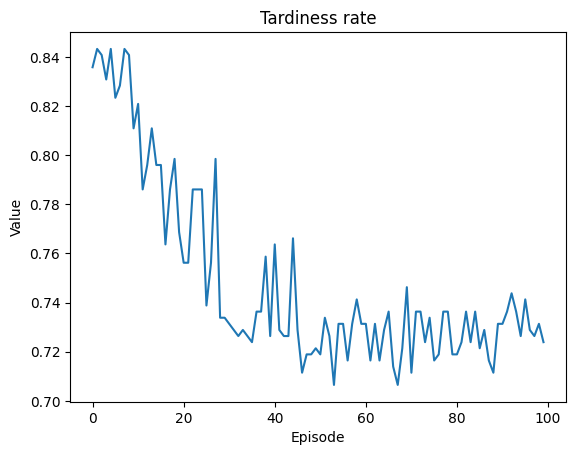

[I 2024-09-28 18:36:55,424] Trial 0 finished with value: -0.7064676616915423 and parameters: {'batch_size': 64, 'hidden_layers': 6, 'neurons_per_layer_0': 226, 'neurons_per_layer_1': 176, 'neurons_per_layer_2': 196, 'neurons_per_layer_3': 132, 'neurons_per_layer_4': 145, 'neurons_per_layer_5': 136}. Best is trial 0 with value: -0.7064676616915423.
Best trial:
{'batch_size': 64, 'hidden_layers': 6, 'neurons_per_layer_0': 226, 'neurons_per_layer_1': 176, 'neurons_per_layer_2': 196, 'neurons_per_layer_3': 132, 'neurons_per_layer_4': 145, 'neurons_per_layer_5': 136}
Best mean reward: 0.7064676616915423


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = make_env() # Create environment

state_dim = env.observation_space.shape[0] # Define the dimension of the state space

output_dim = env.action_space.n

if __name__ == '__main__':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1, show_progress_bar=True) # Use `n_jobs=-1` to use all available cores

    print("Best trial:")
    print(study.best_trial.params)
    print("Best mean reward:", -study.best_value)